Этот набор данных включает результаты A/B-тестирования Cookie Cats для изучения того, что происходит, когда первые ворота в игре перемещаются с уровня 30 на уровень 40.
Когда игрок устанавливал игру, он или она были случайным образом назначены либо к воротам 30, либо к воротам 40.

У нас есть данные от 90 189 игроков, которые установили игру во время проведения AB-теста.


- userid: уникальный номер, который идентифицирует каждого игрока.
- version: Был ли игрок поставлен в контрольную группу (gate30 - ворота 30 уровня) или в группу с перемещенными воротами (gate40  ворота 40 уровня).
- sum_gamerounds: количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
- retention_1: Игрок вернулся и играл через 1 день после установки?
- retention_7: Игрок вернулся и играл через 7 дней после установки?

## Импорт библиотек

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
import statsmodels.api as sm
import pylab 

## Подготовка данных

In [101]:
df = pd.read_csv(r'E:\cookie_cats.csv')

In [102]:
df.sample(10)

,userid,version,sum_gamerounds,retention_1,retention_7
6692,741730,gate_30,4,False,False
51927,5757442,gate_40,3,False,False
17190,1914640,gate_30,67,False,False
9819,1081829,gate_30,52,True,False
4466,497751,gate_30,28,True,False
53578,5949104,gate_40,13,False,False
77366,8566847,gate_40,88,True,True
58067,6427044,gate_40,5,False,False
24366,2709672,gate_40,150,True,True
60615,6714281,gate_30,23,True,False


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [104]:
# посчитаем дубликаты
df['userid'].duplicated().sum()

0

**Вывод**: В датасете 90188 строк, нет дубликатов и нет пропущенных значений

## Определение функций

In [105]:
# тест Мана Уитни

def mannwhitneyfunc(value1,value2,alpha=0.05):

    stat, p = st.mannwhitneyu(value1, value2)

    print('p={:.5f}'.format(p))
    if p > alpha:
        print('Группы не имеют значимых различий')
    else:
        print('Группы  имеют значимые различия')

In [106]:
# тест хи-квадрат
def chi2test(data):
    _, p, _, _ = st.chi2_contingency(data)
    alpha = 0.05

    print('p={:.5f}'.format(p))
    if p > alpha:
        print('Группы не имеют значимых различий')
    else:
        print('Группы  имеют значимые различия')

In [107]:
# функция проверки на нормальность
def normal(df,p_v):
    st.probplot(df['sum_gamerounds'], dist="norm", plot=pylab);
    plt.show()

    _ , p_value = st.shapiro(df['sum_gamerounds'])
    alpha = p_v
    print('p_value={:.5f}'.format(p_value))
    if p_value > alpha:
        print('Распределение нормальное')
    else:
        print('Распределение отличается от нормального')

## Анализ A/B теста

In [6]:
# Создадим столбец с названием группы 
df['group'] = df['version'].apply(lambda x: 'A' if x == 'gate_30' else 'B')


In [7]:
df['sum_gamerounds'].sort_values(ascending=False).head(10)

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
46344     2251
87007     2156
36933     2124
88328     2063
6536      2015
Name: sum_gamerounds, dtype: int64

In [8]:
# 99 перцентиль
np.percentile(df['sum_gamerounds'],99)

493.0

99% игроков не доходят дальше 493 уровня

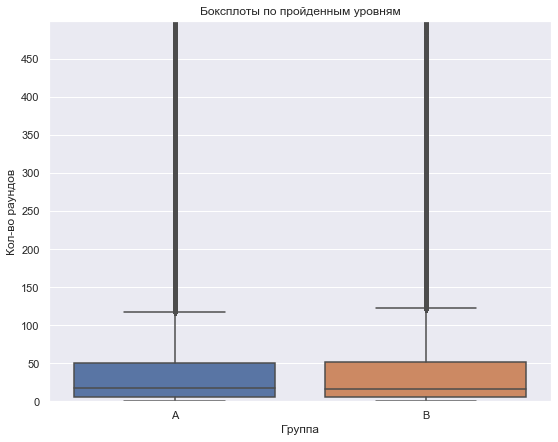

In [9]:
sns.set(rc={'figure.figsize':(9,7)})
ax=sns.boxplot(x = 'group', y = 'sum_gamerounds', data=df)
#ax.set_yscale('log')
ax.set(xlabel='Группа', ylabel='Кол-во раундов')
plt.title('Боксплоты по пройденным уровням',fontsize=12)
plt.ylim(0,500)
plt.yticks(np.arange(0,500,50));



В обеих группах более 75% игроков не проходят дальше 50 уровня

Уберем игроков прошедших более 500 уровня

In [10]:

df = df[df['sum_gamerounds'] < 500]

In [11]:
df[df['sum_gamerounds'] == 0]['group'].value_counts()

B    2057
A    1937
Name: group, dtype: int64

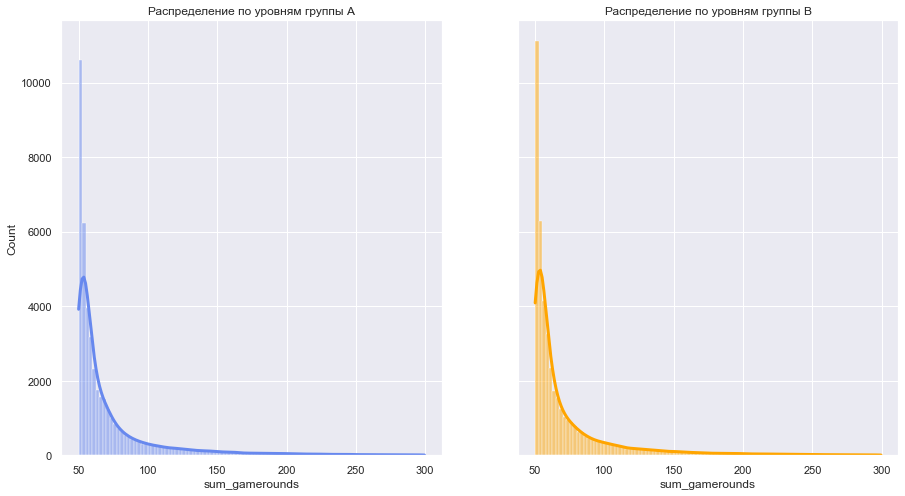

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8),sharey=True)
warnings.filterwarnings('ignore')

sns.set_palette('coolwarm') 
sns.set_style('darkgrid')
plt.title('Распределение игроков по пройденным уровням')



axs = sns.histplot(
    x="sum_gamerounds",  data=df.query('group == "A"'),ax=axes[0],bins=100,line_kws={"lw":3},kde=True) 
axes[0].set_title('Распределение по уровням группы А')
axs.set_xticklabels(np.arange(0,500,50))


axn = sns.histplot(
    x="sum_gamerounds",  data=df.query('group == "B"'),ax=axes[1],bins=100,color='orange',line_kws={"lw":3},kde=True) 
axes[1].set_title('Распределение по уровням группы B')
axn.set_xticklabels(np.arange(0,500,50)); 





В целом, распределения по обеим группам, примерно одинаковые

In [13]:
groupA = df.query('group == "A"')
groupB = df.query('group == "B"')

In [14]:
# функция проверки на нормальность
def normal(df,p_v):
    st.probplot(df['sum_gamerounds'], dist="norm", plot=pylab);
    plt.show()

    _ , p_value = st.shapiro(df['sum_gamerounds'])
    alpha = p_v
    print('p_value={:.5f}'.format(p_value))
    if p_value > alpha:
        print('Распределение нормальное')
    else:
        print('Распределение отличается от нормального')

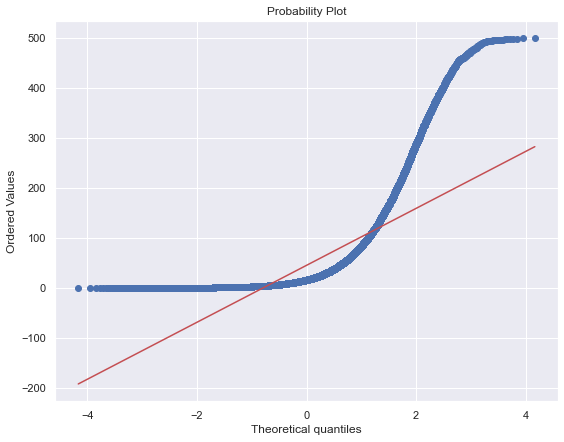

p_value=0.00000
Распределение отличается от нормального


None

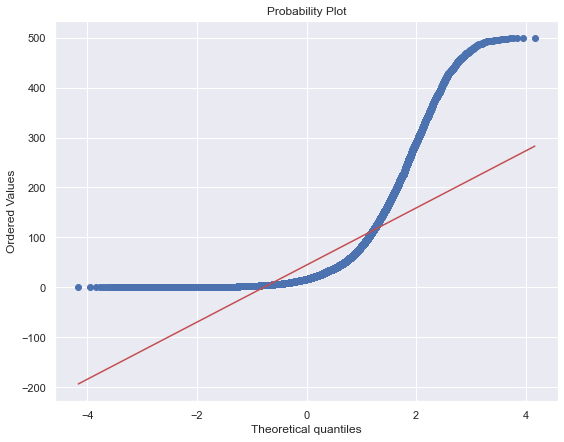

p_value=0.00000
Распределение отличается от нормального


In [15]:
display(normal(groupB,0.05))

normal(groupA,0.05)

Распределения по прохождению уровня отличаются от нормального, соответственно необходимо использовать непараметрический тест

Сформулирем гипотезы:

**H0** -  Кол-во пройденных уровней равны в обеих группах

**H1** -  Кол-во пройденных уровней отличаются 

In [17]:
mannwhitneyfunc(groupB.sum_gamerounds,groupA.sum_gamerounds)

p=0.02457
Группы  имеют значимые различия


In [18]:
groupA.sum_gamerounds.mean(),groupB.sum_gamerounds.mean()

(44.84622334658475, 44.596799609383666)

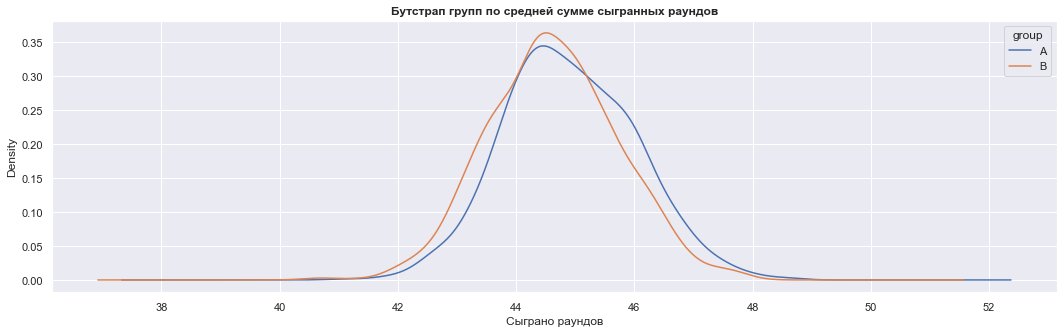

In [66]:
bootstrap_sum = pd.DataFrame([df.sample(8000).groupby('group')['sum_gamerounds'].mean() for i in range(1000)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("Бутстрап групп по средней сумме сыгранных раундов", fontweight="bold")
plt.xlabel("Сыграно раундов")
plt.show()


Чуть более 40% игроков возвращаются в игру на след день после установки, примерно 17% играют в нее спрустя неделю

Сформулирем гипотезы:

**H0** -  Ретеншн первого дня равны в обеих группах

**H1** -  Ретеншн первого дня отличаются 

In [33]:
retention_1 = df.pivot_table(index='group',columns='retention_1',values='userid',aggfunc='count')
retention_7 = df.pivot_table(index='group',columns='retention_7',values='userid',aggfunc='count')

In [67]:
chi2test(retention_1)

p=0.07353
Группы не имеют значимых различий


In [88]:
retention_1_bootstr = pd.DataFrame([df.sample(1000).groupby('group')['retention_1'].mean() for i in range(2000)])



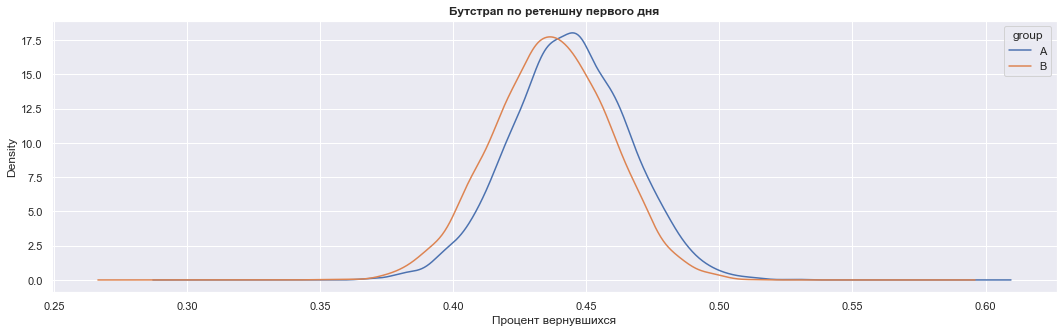

In [94]:
retention_1_bootstr.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("Бутстрап по ретеншну первого дня", fontweight="bold")
plt.xlabel("Процент вернувшихся")
plt.show()

Сформулирем гипотезы:

**H0** -  Ретеншн седьмого дня равны в обеих группах

**H1** -  Ретеншн седьмого дня отличаются 

In [96]:
chi2test(retention_7)

p=0.00115
Группы  имеют значимые различия


In [97]:
retention_7_bootstr = pd.DataFrame([df.sample(1000).groupby('group')['retention_7'].mean() for i in range(2000)])

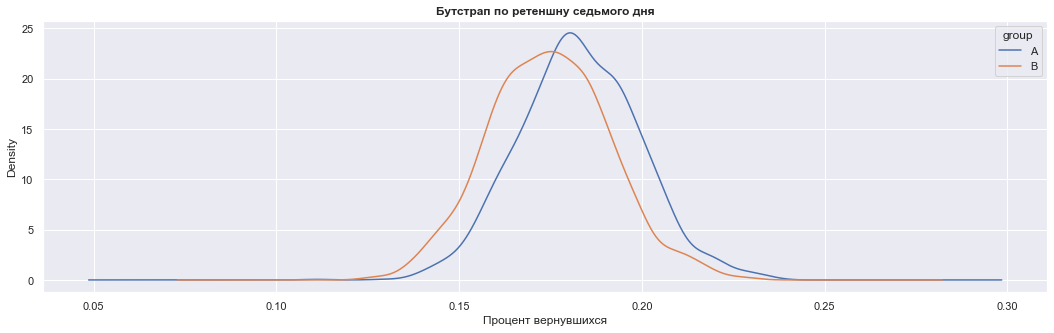

In [98]:
retention_7_bootstr.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("Бутстрап по ретеншну седьмого дня", fontweight="bold")
plt.xlabel("Процент вернувшихся")
plt.show()

## Вывод

Таким образом, в ходе работы мы интерпретировали рез-ы A/B теста, протестировав 3 гипотезы. Можем утверждать, что контрольная группа A (юзеры с воротами на 30 уровне) имеют более высокой ретеншн на 7 день и эти различия значимы. Также эти игроки в среднем проходят больше уровней, чем пользователи тестовой группы

Примечания: в данных мы решили убрать пользователей, прошедших более 500 уровней (менее 1% игроков) т.к на этих пользователей изменение скорее всего не повлияет